This notebook contains analysis to show the benefits of the EM algorithm in Emu over use of just the mapper, minimap2.

1. Evaluation of Emu over concurrent EM iterations

2. Evaluation of Emu with use of alternative mapper, BWA-mem

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## helper functions

# reduce df to only taxa [index] with at least one val > thresh 
def trim_df_treshold(df, thresh):
    df_results = df.copy()
    df_results['max'] = df_results.max(axis=1)
    df_results = df_results[df_results['max'] > thresh]
    df_results = df_results.drop(columns=['max'])
    df_results.loc['other']= 100 - df_results.sum()
    return df_results

def trim_df_treshold_diff(df, maxthresh, minthresh):
    df_results = df.copy()
    df_results['max'] = df_results.max(axis=1)
    df_results['min'] = df_results.min(axis=1)
    df_results = df_results[(df_results['min'] < minthresh)|(df_results['max'] > maxthresh)]
    df_results = df_results.drop(columns=['max', 'min'])
    return df_results

def extract_abundance(in_path, rank, in_col, out_col, taxa_col='name', multiplier=1):
    ext = in_path.split(".")[-1]
    if ext == "tsv":
        df_all = pd.read_csv(in_path, sep='\t')
    if ext == "csv":
        df_all = pd.read_csv(in_path)
    df = df_all[[taxa_col, in_col]].groupby(taxa_col).sum().reset_index()
    df = df.rename(columns={in_col:out_col, taxa_col:rank}).dropna()
    df[out_col] = df[out_col] * multiplier
    return df

def extract_abundance_primary(in_path, rank, out_col):
    return extract_abundance(in_path, rank, 'abundance', out_col, taxa_col=rank, multiplier=100)

def extract_abundance_theoretical(in_path, rank):
    return extract_abundance(in_path, rank, 'abundance', 'theoretical', taxa_col=rank)

def extract_abundance_emu(in_path, rank, out_col='Emu'):
    return extract_abundance(in_path, rank, 'abundance', out_col, taxa_col=rank, multiplier=100)

# print L1 and L2 norm for all columns compared to col: 'compare_col_name'
def print_L1_L2(df, compare_col_name):
    df_results = df.copy().fillna(0)
    relative_truth = df_results[compare_col_name]
    df_results = df_results.drop(columns=[compare_col_name])
    df_results = df_results.sub(relative_truth, axis=0).fillna(0)
    df_results_L1 = df_results.applymap(lambda x: abs(x))
    L1 = df_results_L1.sum() * .01
    df_results_L2 = df_results.applymap(lambda x: (x**2))
    L2 = df_results_L2.sum().apply(lambda x: math.sqrt(x)) * .01
    print(f"L1:\n{L1.to_string()}\n")
    print(f"L2:\n{L2.to_string()}\n")
    
# print precision and recall stats for all columns compared to col: 'compare_col_name'
def print_precision_recall(df, compare_col_name):
    df_results = df.copy()
    df_results = df_results.replace(0,np.NaN)
    df_presence = df_results.notnull()
    df_counts = df_presence.sum()
    df_true_positive = df_presence[df_presence[compare_col_name]]
    true_positives = df_true_positive.sum()
    precision = true_positives/df_counts
    sensitivity = true_positives/df_counts[compare_col_name]
    stats = {}
    stats['true_positives'] = df_true_positive.sum()
    stats['false_positives'] = df_counts - true_positives
    stats['precision'] = precision
    stats['recall'] = sensitivity
    stats['f_score'] = 2*precision*sensitivity/(precision+sensitivity)
    display(pd.DataFrame(stats))
    print("\n")

# Make absolute diff in relative abundance heatmaps for a given sample, sequencing type, and taxonomic rank.
def absolute_diff_heatmap(df, output_name):
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    if 'unclassified' in df.index:
        df.drop(index=['unclassified'], inplace=True)
    if 'theoretical' in df.columns:
        df.rename(columns={'theoretical': 'truth'}, inplace=True)
    diffs_df = df.copy().fillna(0)
    for col in diffs_df.columns:
        if col != 'truth':
            diffs_df[col] = diffs_df[col] - diffs_df['truth']
    diffs_df.drop(columns=['truth'], inplace=True)

    _, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(diffs_df, yticklabels=1, xticklabels=1, cmap="RdBu_r", center=0, vmin=-5, vmax=5, square=True)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7,
                     box.height])
    plt.setp(ax.get_yticklabels(), fontsize=7)
    plt.setp(ax.get_xticklabels(), fontsize=7)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.subplots_adjust(left=0.35)
    plt.savefig(f"./results_heatmap/{output_name}.png")
    return diffs_df

def top_num_both_dfs(df1, df2, NUM_KEPT=20):
    df1_copy = df1.copy()
    df1_copy['max'] = df1_copy.max(axis=1)
    df2_copy = df2.copy()
    df2_copy['max'] = df2_copy.max(axis=1)
    df1_copy = df1_copy.sort_values(by='max', ascending=False)[:NUM_KEPT + 5]
    df2_copy = df2_copy.sort_values(by='max', ascending=False)[:NUM_KEPT + 5]
    joined_df = df1_copy.join(df2_copy, how='outer', lsuffix='1', rsuffix='2')
    joined_df['overall_max'] = joined_df.max(axis=1)
    joined_df = joined_df.sort_values(by='overall_max', ascending=False)
    all_indices = list(joined_df.index)
    filtered_indices = [index for index in all_indices if index in df1.index and index in df2.index]
    return sorted(filtered_indices[:NUM_KEPT])

def top_num_df(df, NUM_KEPT=20):
    df_copy = df.copy()
    df_copy['max'] = df_copy.max(axis=1)
    df_copy = df_copy.sort_values(by='max', ascending=False)
    indices = list(df_copy.index)
    return sorted(indices[:NUM_KEPT])

def trim_df_keep_some(df, keep_these):
    df_copy = df.copy()
    df_copy = df_copy.loc[keep_these, :]
    df_copy.loc['other'] = 100 - df_copy.sum()
    return df_copy

### EM concurrent iterations

In [3]:
## ZymoBIOMICS - paths
zymo_nanopore_truth_path = "./results_quantitative/truth/zymo_nanopore_assembled_minimap_primary.tsv"
zymo_nanopore_emu_path = "./results_quantitative/Emu_v2_iterations/zymo_nanopore_iters_rel-abundance-threshold-0.0001.tsv"

def get_iter(count):
    zymo_nanopore_emu_iters_base = "./results_quantitative/Emu_v2_iterations/zymo_nanopore_iters"
    return f"{zymo_nanopore_emu_iters_base}_{count}.tsv"

L1:
1        0.253779
2        0.109467
3        0.072895
4        0.057585
5        0.049551
10       0.037626
15       0.035939
20       0.035661
final    0.034468

L2:
1        0.119852
2        0.067093
3        0.046881
4        0.037042
5        0.031547
10       0.023163
15       0.021980
20       0.021784
final    0.021371



true_positives  false_positives  precision  recall   f_score
truth               8                0   1.000000     1.0  1.000000
1                   8               43   0.156863     1.0  0.271186
2                   8               15   0.347826     1.0  0.516129
3                   8               10   0.444444     1.0  0.615385
4                   8                7   0.533333     1.0  0.695652
5                   8                6   0.571429     1.0  0.727273
10                  8                6   0.571429     1.0  0.727273
15                  8                6   0.571429     1.0  0.727273
20                  8                6   0.571429     1.0  0.727273
final               8                6   0.571429     1.0  0.727273

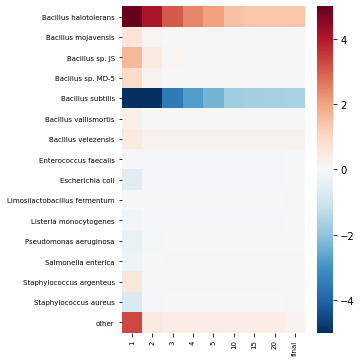

In [4]:
zymo_truth_species = extract_abundance_primary(zymo_nanopore_truth_path, 'species', 'truth')
zymo_emu_species_1 = extract_abundance_emu(get_iter(1), 'species', '1')
zymo_emu_species_2 = extract_abundance_emu(get_iter(2), 'species', '2')
zymo_emu_species_3 = extract_abundance_emu(get_iter(3), 'species', '3')
zymo_emu_species_4 = extract_abundance_emu(get_iter(4), 'species', '4')
zymo_emu_species_5 = extract_abundance_emu(get_iter(5), 'species', '5')
zymo_emu_species_10 = extract_abundance_emu(get_iter(10), 'species', '10')
zymo_emu_species_15 = extract_abundance_emu(get_iter(15), 'species', '15')
zymo_emu_species_20 = extract_abundance_emu(get_iter(20), 'species', '20')
zymo_emu_species_final = extract_abundance_emu(zymo_nanopore_emu_path, 'species', 'final')


df_results_zymo_nanopore_iters = zymo_truth_species
df_results_zymo_nanopore_iters = pd.merge(df_results_zymo_nanopore_iters, zymo_emu_species_1, how='outer', on=['species'])
df_results_zymo_nanopore_iters = pd.merge(df_results_zymo_nanopore_iters, zymo_emu_species_2, how='outer', on=['species'])
df_results_zymo_nanopore_iters = pd.merge(df_results_zymo_nanopore_iters, zymo_emu_species_3, how='outer', on=['species'])
df_results_zymo_nanopore_iters = pd.merge(df_results_zymo_nanopore_iters, zymo_emu_species_4, how='outer', on=['species'])
df_results_zymo_nanopore_iters = pd.merge(df_results_zymo_nanopore_iters, zymo_emu_species_5, how='outer', on=['species'])
df_results_zymo_nanopore_iters = pd.merge(df_results_zymo_nanopore_iters, zymo_emu_species_10, how='outer', on=['species'])
df_results_zymo_nanopore_iters = pd.merge(df_results_zymo_nanopore_iters, zymo_emu_species_15, how='outer', on=['species'])
df_results_zymo_nanopore_iters = pd.merge(df_results_zymo_nanopore_iters, zymo_emu_species_20, how='outer', on=['species'])
df_results_zymo_nanopore_iters = pd.merge(df_results_zymo_nanopore_iters, zymo_emu_species_final, how='outer', on=['species'])
df_results_zymo_nanopore_iters = df_results_zymo_nanopore_iters.set_index('species')

df_results_zymo_nanopore_iters[df_results_zymo_nanopore_iters<.01]=0
print_L1_L2(df_results_zymo_nanopore_iters, 'truth')
print_precision_recall(df_results_zymo_nanopore_iters, 'truth')

df_results_zymo_nanopore_iters_top = trim_df_keep_some(df_results_zymo_nanopore_iters, top_num_df(df_results_zymo_nanopore_iters, 15))
zymo_nanopore_iters_diff = absolute_diff_heatmap(df_results_zymo_nanopore_iters_top, "zymo_nanopore_iters")




### Emu with BWA-Mem

In [5]:
## ZymoBIOMICS - paths
zymo_nanopore_emu_path = "./results_quantitative/Emu_v2.0.1/zymo_nanopore_rel-abundance-threshold-0.0001.tsv"
zymo_nanopore_minimap_path = "./results_quantitative/Minimap2/zymo_nanopore_minimap2.tsv"
zymo_nanopore_emu_bwa_path = "./results_quantitative/Emu_v2_BWA/zymo_nanopore_bwa_mem_rel-abundance-threshold-0.0001.tsv"
zymo_nanopore_bwa_path = "./results_quantitative/BWA/zymo_nanopore_bwa_primary.tsv"

## MBARC paths
mbarc_ncbi_theoretical_path = "./results_quantitative/truth/mbarc_ncbi_theoretical.csv"
mbarc_emu_path = "./results_quantitative/Emu_v2.0.1/mbarc_ncbi_rel-abundance.tsv"
mbarc_minimap_path = "./results_quantitative/Minimap2/mbarc_ncbi_minimap2.tsv"
mbarc_emu_bwa_path = "./results_quantitative/Emu_v2_BWA/mbarc_ncbi_bwa_mem_rel-abundance.tsv"
mbarc_bwa_path = "./results_quantitative/BWA/mbarc_ncbi_bwa_primary.tsv"


In [6]:
## ZymoBIOMICS Nanopore - species Level

zymo_truth_species = extract_abundance_primary(zymo_nanopore_truth_path, 'species', 'truth')
zymo_emu_species = extract_abundance_emu(zymo_nanopore_emu_path, 'species', 'Emu_default')
zymo_minimap_species = extract_abundance_primary(zymo_nanopore_minimap_path, 'species', 'Minimap2')
zymo_emu_bwa_species = extract_abundance_emu(zymo_nanopore_emu_bwa_path, 'species', 'Emu_BWA-mem')
zymo_bwa_species = extract_abundance_primary(zymo_nanopore_bwa_path, 'species', 'BWA-mem')

df_results_zymo_nanopore_species = zymo_truth_species
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_emu_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_minimap_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_emu_bwa_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_bwa_species, how='outer', on=['species'])

df_results_zymo_nanopore_species.to_csv("./results_spreadsheets/BWA_comp_zymo_nanopore_species.tsv", sep='\t')
df_results_zymo_nanopore_species = df_results_zymo_nanopore_species.set_index("species")

df_results_zymo_nanopore_species[df_results_zymo_nanopore_species<.01]=0
print_L1_L2(df_results_zymo_nanopore_species, 'truth')
print_precision_recall(df_results_zymo_nanopore_species, 'truth')


L1:
Emu_default    0.034319
Minimap2       0.171791
Emu_BWA-mem    0.053556
BWA-mem        0.206455

L2:
Emu_default    0.021271
Minimap2       0.084029
Emu_BWA-mem    0.027197
BWA-mem        0.106724



true_positives  false_positives  precision  recall   f_score
truth                     8                0   1.000000     1.0  1.000000
Emu_default               8                6   0.571429     1.0  0.727273
Minimap2                  8               45   0.150943     1.0  0.262295
Emu_BWA-mem               8               18   0.307692     1.0  0.470588
BWA-mem                   8               56   0.125000     1.0  0.222222

In [7]:
## mbarc - species Level

mbarc_theoretical_species = extract_abundance_theoretical(mbarc_ncbi_theoretical_path, 'species')
mbarc_emu_species = extract_abundance_emu(mbarc_emu_path, 'species', 'Emu_default')
mbarc_minimap_species = extract_abundance_primary(mbarc_minimap_path, 'species', 'Minimap2')
mbarc_emu_bwa_species = extract_abundance_emu(mbarc_emu_bwa_path, 'species', 'Emu_BWA-mem')
mbarc_bwa_species = extract_abundance_primary(mbarc_bwa_path, 'species', 'BWA-mem')

df_results_mbarc_species = mbarc_theoretical_species
df_results_mbarc_species = pd.merge(df_results_mbarc_species, mbarc_emu_species, how='outer', on=['species'])
df_results_mbarc_species = pd.merge(df_results_mbarc_species, mbarc_minimap_species, how='outer', on=['species'])
df_results_mbarc_species = pd.merge(df_results_mbarc_species, mbarc_emu_bwa_species, how='outer', on=['species'])
df_results_mbarc_species = pd.merge(df_results_mbarc_species, mbarc_bwa_species, how='outer', on=['species'])

df_results_mbarc_species.to_csv("./results_spreadsheets/BWA_comp_mbarc_species.tsv", sep='\t')
df_results_mbarc_species = df_results_mbarc_species.set_index("species")


cutoff = 10/958655 * 100
df_results_mbarc_species[df_results_mbarc_species < cutoff]=0
print_precision_recall(df_results_mbarc_species, 'theoretical')
print_L1_L2(df_results_mbarc_species, 'theoretical')



true_positives  false_positives  precision  recall   f_score
theoretical              26                0   1.000000     1.0  1.000000
Emu_default              26                0   1.000000     1.0  1.000000
Minimap2                 26               12   0.684211     1.0  0.812500
Emu_BWA-mem              26                3   0.896552     1.0  0.945455
BWA-mem                  26                8   0.764706     1.0  0.866667



L1:
Emu_default    0.000033
Minimap2       0.012987
Emu_BWA-mem    0.000167
BWA-mem        0.000771

L2:
Emu_default    0.000013
Minimap2       0.006799
Emu_BWA-mem    0.000056
BWA-mem        0.000280

